**Data Collection Section of the Report**

**Introduction:**
In this section of the report, we will discuss the data collection process for Project 1, which focuses on Sales Trends and Customer Insights in the e-commerce business. This project is part of the Descriptive Analysis phase, aimed at providing a clear understanding of past events and trends within the e-commerce dataset. Specifically, we will gather data related to customer orders, including recency, which is a critical component for RFM (Recency, Frequency, Monetary) analysis.

**About the Dataset:**
The dataset used for this analysis is `bigquery-public-data.thelook_ecommerce`. It is stored on Google BigQuery, a powerful cloud-based data warehouse. The dataset contains various tables that provide detailed information about e-commerce transactions, including orders, order items, and user profiles. Here are some key tables from the dataset:

- `orders`: Contains information about individual orders, including order IDs, order dates, and user IDs.
- `order_items`: Provides details about the items within each order, including product IDs, sale prices, and associated order IDs.
- `users`: Contains user profiles, including gender, age, and other demographic information.

**Data Collection Query:**
To perform the analysis for Project 1, we utilized a SQL query to extract relevant data from the dataset. The query involves the calculation of recency, a key component for understanding customer behavior and retention. Below is the query used for data collection:


In [2]:
import os
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/ramdh/AppData/Roaming/gcloud/application_default_credentials.json"
os.environ["GOOGLE_CLOUD_PROJECT"] = "fluted-gateway-306407"


client = bigquery.Client()

In [16]:
#data processing
import numpy as np
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math as math

from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

In [12]:
# BigSQL query
sql_query = """
WITH LastPurchaseDates AS (
  SELECT
    user_id,
    MAX(created_at) AS last_purchase_date
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`
  GROUP BY
    user_id
)

SELECT
  o.order_id,
  DATE_TRUNC(DATE(o.created_at), MONTH) AS order_date,
  ABS(DATE_DIFF(o.created_at, lpd.last_purchase_date, DAY)) AS recency_days,
  o.status AS order_status,
  DATE_DIFF(o.shipped_at, o.created_at, DAY) AS shipping_days,
  o.user_id,
  u.gender,
  u.age,
  oi.product_id,
  o.num_of_item AS num_of_item,
  ROUND(oi.sale_price, 2) AS sale_price,
  ROUND(p.cost, 2) AS product_cost,
  ROUND((oi.sale_price - p.cost), 2) AS profit,
  p.category AS product_category,
  p.brand,
  p.department AS product_department,
  dc.name AS distribution_center
FROM
  `bigquery-public-data.thelook_ecommerce.orders` AS o
JOIN
  `bigquery-public-data.thelook_ecommerce.order_items` AS oi
ON
  o.order_id = oi.order_id
JOIN
  `bigquery-public-data.thelook_ecommerce.users` AS u
ON
  o.user_id = u.id
JOIN  `bigquery-public-data.thelook_ecommerce.products` AS p
ON 
  oi.product_id = p.id
LEFT JOIN
  LastPurchaseDates AS lpd
ON
  o.user_id = lpd.user_id
LEFT JOIN
  `bigquery-public-data.thelook_ecommerce.distribution_centers` AS dc
ON
  dc.id = p.distribution_center_id
"""

# Run the query
query_job = client.query(sql_query)

# Fetch the results
results = query_job.result()


df = results.to_dataframe()
df.to_csv('data\order_data.csv', index=False)

**Explanation of the Query:**
- We begin by creating a Common Table Expression (CTE) named `LastPurchaseDates` to find the last purchase date for each user. This is essential for calculating recency.
- The main query joins multiple tables, including `orders`, `order_items`, and `users`, to gather relevant information about each order, such as order date, product details, and user demographics.
- Within the main query, we calculate recency by using the `DATE_DIFF` function to determine the number of days between the order date and the user's last purchase date. This provides insights into how recently each customer has made a purchase.

**Purpose of Recency Calculation:**
Recency is a crucial metric for RFM analysis. It helps us understand how recently customers have interacted with the e-commerce platform. By calculating recency, we can segment customers based on their activity levels, identify loyal and inactive customers, and tailor marketing strategies to re-engage dormant customers. This analysis enables the e-commerce business to optimize customer retention and maximize revenue.

In the subsequent sections of this report, we will delve deeper into the findings and insights derived from this data collection process, providing a narrative-driven storytelling approach to understand past sales trends and customer behavior.

In [26]:
df = pd.read_csv('data/order_data.csv')

In [27]:
df

,order_id,order_date,recency_days,order_status,shipping_days,user_id,gender,age,product_id,num_of_item,sale_price,product_cost,profit,product_category,brand,product_department,distribution_center
0,10,2020-03-01,1293,Shipped,2.0,8,F,62,13123,1,49.99,23.45,26.54,Swim,Sons of Anarchy,Women,Houston TX
1,23,2023-01-01,0,Shipped,0.0,24,F,44,1952,1,145.00,64.23,80.77,Fashion Hoodies & Sweatshirts,TEXTILE Elizabeth and James,Women,Houston TX
2,24,2021-10-01,0,Shipped,2.0,26,F,63,14274,1,3.99,1.57,2.42,Accessories,Greatlookz,Women,Houston TX
3,29,2020-11-01,0,Shipped,2.0,34,F,48,3273,1,128.00,53.63,74.37,Dresses,Jessica Simpson,Women,Los Angeles CA
4,35,2023-04-01,0,Shipped,0.0,39,F,35,446,2,41.99,25.15,16.84,Tops & Tees,Fashion Forever,Women,Mobile AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181522,125144,2022-05-01,0,Processing,NaN,99939,M,26,21087,1,89.50,48.33,41.17,Jeans,Tommy Hilfiger,Men,Memphis TN
181523,125167,2023-07-01,0,Processing,NaN,99959,M,55,25965,2,19.00,9.84,9.16,Underwear,Mundo Unico,Men,Memphis TN
181524,125167,2023-07-01,0,Processing,NaN,99959,M,55,19334,2,80.00,36.32,43.68,Sweaters,Schaefer Outfitters,Men,Los Angeles CA
181525,125196,2023-03-01,0,Processing,NaN,99987,M,32,25043,2,9.38,6.01,3.37,Socks,HUGO BOSS,Men,Chicago IL


In [28]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [29]:
daily_orders = df.groupby('order_date')['order_id'].nunique().reset_index()

# EDA

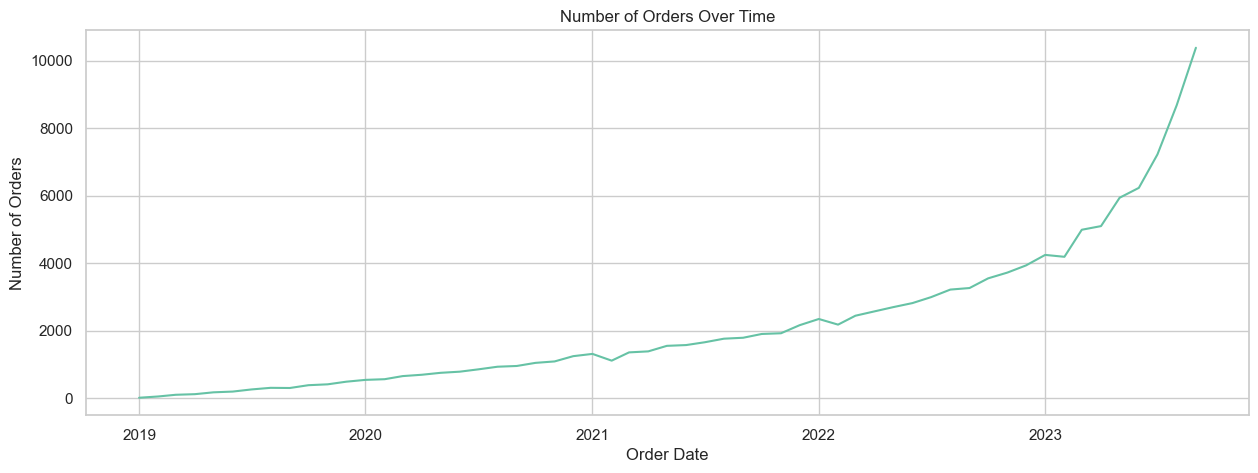

In [30]:
# Set the figure size
plt.figure(figsize=(15, 5))

# Create a line plot
sns.lineplot(x='order_date', y='order_id', data=daily_orders)

# Set the title and labels
plt.title('Number of Orders Over Time')
plt.xlabel('Order Date')
plt.ylabel('Number of Orders')

# Show the plot
plt.show()

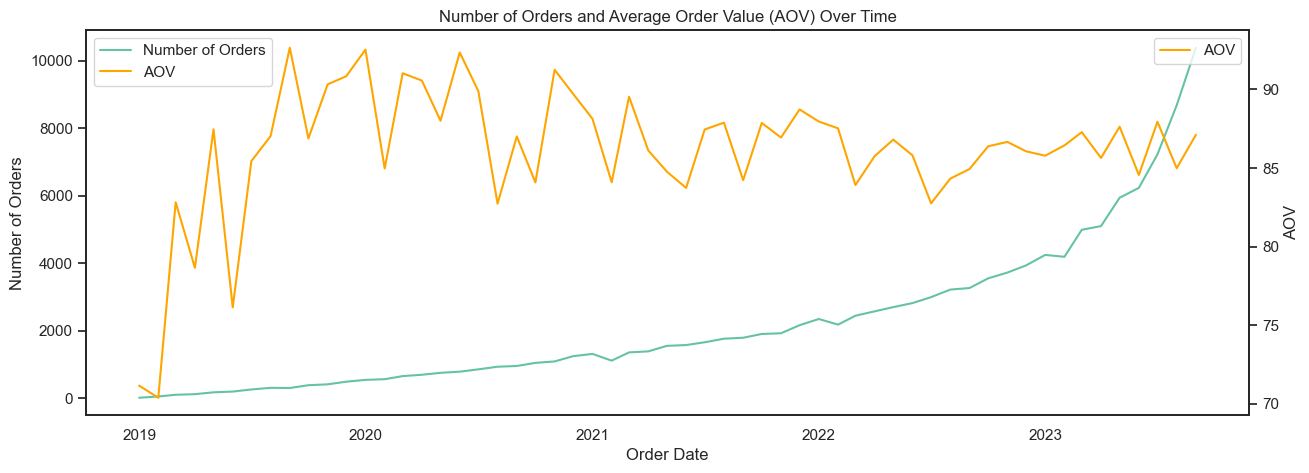

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by 'order_date' and calculate the number of unique order IDs and AOV for each date
daily_orders_aov = df.groupby('order_date').agg({'order_id': 'nunique', 'sale_price': 'sum'}).reset_index()
daily_orders_aov['AOV'] = daily_orders_aov['sale_price'] / daily_orders_aov['order_id']

# Set the figure size
plt.figure(figsize=(15, 5))

# Create the first y-axis for Number of Orders
ax1 = sns.lineplot(x='order_date', y='order_id', data=daily_orders_aov, label='Number of Orders')

# Create the second y-axis for AOV
ax2 = ax1.twinx()
sns.lineplot(x='order_date', y='AOV', data=daily_orders_aov, color='orange', ax=ax2, label='AOV')

# Set the title and labels
plt.title('Number of Orders and Average Order Value (AOV) Over Time')
ax1.set_xlabel('Order Date')
ax1.set_ylabel('Number of Orders')
ax2.set_ylabel('AOV')

# Show a legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.show()


In [50]:
# Group the data by 'order_date' (month) and calculate the number of unique order IDs and AOV for each month
monthly_orders_aov = df.groupby(df['order_date'].dt.to_period("M")).agg({'order_id': 'nunique', 'sale_price': 'sum'}).reset_index()
monthly_orders_aov['AOV'] = monthly_orders_aov['sale_price'] / monthly_orders_aov['order_id']

In [48]:
#set grid false for all charts
sns.set_style("white", {'axes.grid' : False})

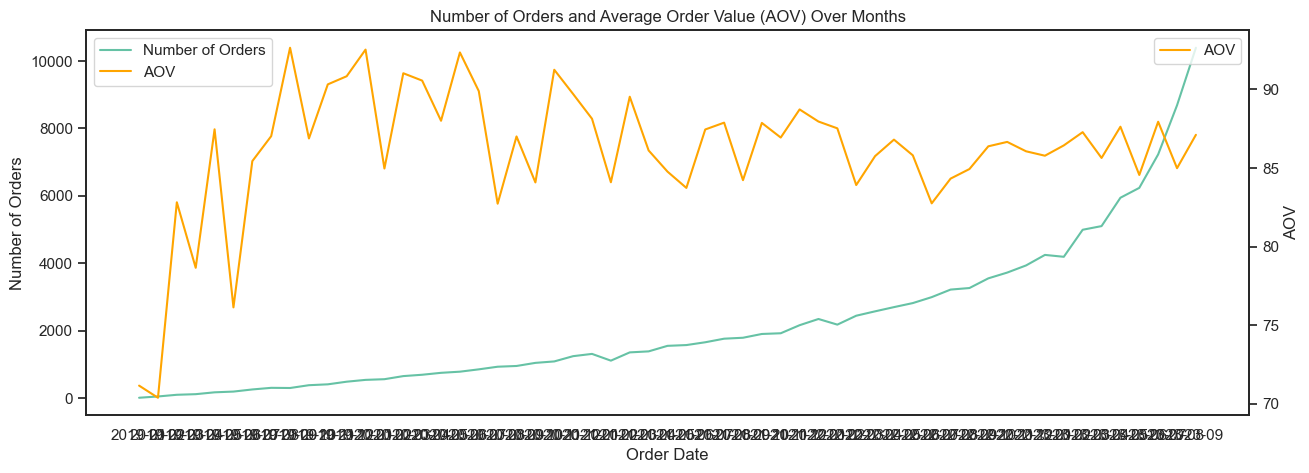

In [51]:
# Convert 'order_date' to strings representing month and year
monthly_orders_aov['order_date'] = monthly_orders_aov['order_date'].dt.strftime('%Y-%m')

# Set the figure size
plt.figure(figsize=(15, 5))

# Create the first y-axis for Number of Orders
ax1 = sns.lineplot(x='order_date', y='order_id', data=monthly_orders_aov, label='Number of Orders')

# Create the second y-axis for AOV
ax2 = ax1.twinx()
sns.lineplot(x='order_date', y='AOV', data=monthly_orders_aov, color='orange', ax=ax2, label='AOV')

# Set the title and labels
plt.title('Number of Orders and Average Order Value (AOV) Over Months')
ax1.set_xlabel('Order Date')
ax1.set_ylabel('Number of Orders')
ax2.set_ylabel('AOV')

# Show a legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.show()


todo:
- add shipping days
- add user_id


There are a number of possible reasons why the number of users of a product or service may be increasing while the frequencies and average order values (AOV) remain stagnant. Some of the most likely explanations include:

- New users are not as engaged as existing users. New users may be less likely to use a product or service frequently or to spend a lot of money on it, especially if they are still trying it out or learning how to use it.
- The product or service is no longer meeting the needs of existing users. If the product or service is not evolving or improving, existing users may become bored or frustrated and start to use it less often or to spend less money on it.
- There is increased competition. If there are other products or services that are similar to yours and that are offering better value or a better user experience, then your users may be switching to those products or services.
The overall economy is struggling. If people are having less money to spend, they may be cutting back on their spending on non-essential goods and services.

# Visualizing Distributions

## Sale Price, Profit, and Categorical variables

### Average Sale Price and Profit by Product Category

![Alt text](image-1.png)

### Average Sale Price and Profit by Gender

![Alt text](image-2.png)